# Covid-19 United States Growth Modeling

### Data Source:
#### 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering

Link: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy.optimize import leastsq

import datetime
import warnings

from lib import get_or_update_source_data

warnings.filterwarnings('ignore')

In [2]:
get_or_update_source_data()

Updating source data


In [3]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv') 

## Report Update Information:

In [4]:
print(f'Report Generated On:\t\t{datetime.datetime.now().strftime("%m/%d/%y")}\nData Source Updated On:\t\t{df.columns[-1]}')

Report Generated On:		03/14/20
Data Source Updated On:		3/14/20


### On 3/10/20, data stopped being reported by county and began reporting at the state level:

Source: https://github.com/CSSEGISandData/COVID-19/issues/382

In [5]:
us_states_by_county = df[(df["Country/Region"]=='US') & (df["Province/State"].str.contains(','))]

In [6]:
us_states = df[(df["Country/Region"]=='US') & (df["Province/State"].str.contains(',').apply(lambda x: not x))]

In [7]:
states_sum_by_county = us_states_by_county.sum().to_frame().drop(["Province/State", "Country/Region", "Lat", "Long"])
states_sum_by_county = states_sum_by_county[(states_sum_by_county[0]!=0)]
states_sum_by_county.columns = ["Confirmed Cases"]
states_sum_by_county.index = [datetime.datetime.strptime(index, "%m/%d/%y") for index in states_sum_by_county.index]

In [8]:
states_sum = us_states.sum().to_frame().drop(["Province/State", "Country/Region", "Lat", "Long"])
states_sum = states_sum[(states_sum[0]!=0)]
states_sum.columns = ["Confirmed Cases"]
states_sum.index = [datetime.datetime.strptime(index, "%m/%d/%y") for index in states_sum.index]

In [9]:
totals = pd.concat([states_sum_by_county.loc[:'2020-03-9'], states_sum.loc['2020-03-10':]], axis=0)

# Data and Graphs:

### Follows typical exponential growth starting around Feb 23rd:

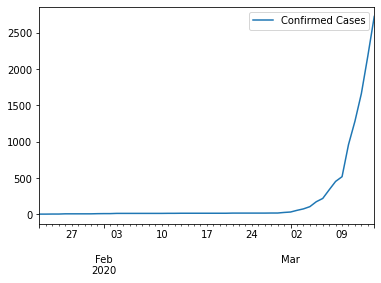

In [10]:
totals.plot()

### Viewing growth from a log scale:

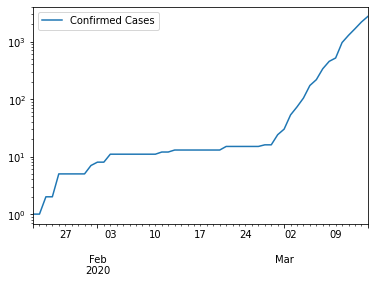

In [11]:
totals.plot(logy=True)

### Data in Numbers - US Confirmed Cases (From Feb 23rd):

In [12]:
totals = totals.loc['2020-02-23':]
totals

,Confirmed Cases
2020-02-23,15
2020-02-24,15
2020-02-25,15
2020-02-26,15
2020-02-27,16
2020-02-28,16
2020-02-29,24
2020-03-01,30
2020-03-02,53
2020-03-03,73


# Generating Lines of Best Fit:

### We can see that fitting to the data seems to work pretty well

In [13]:
m, b = np.polyfit(list(range(len(totals.index))), np.log(list(totals['Confirmed Cases'])), 1)

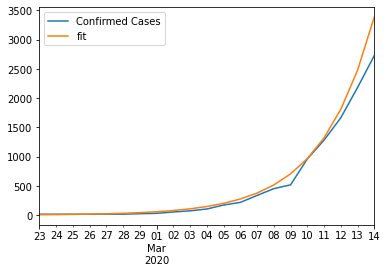

In [14]:
xs = np.linspace(0.0, float(len(totals.index)), len(totals.index))
ys = np.exp(m*xs + b)
totals['fit'] = ys
totals.plot()

## With a log-scale for a linear relationship:

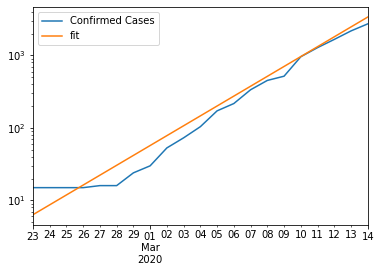

In [15]:
totals.plot(logy=True)

# Projections:

### Note: These projections are only estimations, and represent my opinions and mine alone. 

For Official Coronavirus information please visit https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/

### We use a logistic growth model to calculate our projections
Unlike exponential growth, logistic growth tapers off over time:
![title](assets/logistic_growth.png)

In [16]:
# Plot results with predictions for ten days into the future
num_pred_days = 10

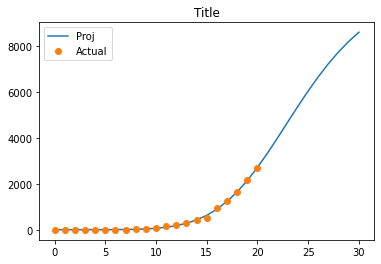

In [17]:
def logistic4(x, A, B, C, D):
    """4PL lgoistic equation."""
    return ((A-D)/(1.0+((x/C)**B))) + D

def residuals(p, y, x):
    """Deviations of data from fitted 4PL curve"""
    A,B,C,D = p
    err = y-logistic4(x, A, B, C, D)
    return err

def peval(x, p):
    """Evaluated value at x with current parameters."""
    A,B,C,D = p
    return logistic4(x, A, B, C, D)


x = np.array(range(len(totals.index)))
y_meas = totals['Confirmed Cases'].astype(float)

# Initial guess for parameters
p0 = [0, 1, 1, 1]

# Fit equation using least squares optimization
plsq = leastsq(residuals, p0, args=(y_meas, x))

x_hat = np.array(range(len(totals.index) + num_pred_days))
plt.plot(x_hat,peval(x_hat,plsq[0]),x,y_meas,'o')
plt.title('Title')
plt.legend(['Proj', 'Actual'], loc='upper left')

### Projections in numbers:

In [18]:
proj = pd.DataFrame(peval(x_hat,plsq[0]))
proj['Actual'] = np.concatenate((np.array(y_meas), np.array([np.NaN for _ in range(num_pred_days)])), axis=0)
proj.index = [datetime.date(2020,2,23) + datetime.timedelta(days=x) for x in range(len(x_hat))]
proj.columns = ['Proj', 'Actual']
proj['Proj Growth'] = [max(list(proj['Proj'])[idx] - list(proj['Proj'])[idx - 1], 0.0) for idx, _ in enumerate(list(proj['Proj']))]
proj['Actual Growth'] = [max(y_meas[idx] - y_meas[idx - 1], 0.0) for idx, _ in enumerate(list(y_meas))] + [np.NaN for _ in range(num_pred_days)]
proj['Actual / Proj Diff'] = proj['Actual'] - proj['Proj']
proj['Actual / Proj Growth Diff'] = proj['Actual Growth'] - proj['Proj Growth']
proj.astype(object).fillna("TBD")

,Proj,Actual,Proj Growth,Actual Growth,Actual / Proj Diff,Actual / Proj Growth Diff
2020-02-23,25.672879,15,0.000000,0,-10.6729,0
2020-02-24,25.672959,15,0.000080,0,-10.673,-7.96913e-05
2020-02-25,25.677582,15,0.004624,0,-10.6776,-0.00462357
2020-02-26,25.723972,15,0.046389,0,-10.724,-0.0463895
2020-02-27,25.950452,16,0.226480,1,-9.95045,0.77352
2020-02-28,26.704400,16,0.753948,0,-10.7044,-0.753948
2020-02-29,28.687486,24,1.983086,8,-4.68749,6.01691
2020-03-01,33.135814,30,4.448328,6,-3.13581,1.55167
2020-03-02,42.030902,53,8.895088,23,10.9691,14.1049
2020-03-03,58.333307,73,16.302404,20,14.6667,3.6976


In [19]:
print(f"The model predicts {round(proj['Proj'][datetime.date.today()])} confirmed cases by the end of today.")
print(f"The model predicts {round(proj['Proj'][-1])} confirmed cases in ten day's time.")

The model predicts 2735.0 confirmed cases by the end of today.
The model predicts 8617.0 confirmed cases in ten day's time.
